<h1>My data</h1>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

<h1>Data Prepare</h1>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
r_cols = ['user_id', 'player_id', 'rating']
df = pd.read_csv('user_team.csv', sep=',', names=r_cols, encoding='latin-1')

In [4]:
df.head()

,user_id,player_id,rating
0,20082019-YPX56QBJ-S3FCYU12-S3FCYU12,zgqjravo,1
1,20082019-YPX56QBJ-S3FCYU12-S3FCYU12,nngznqno,1
2,20082019-YPX56QBJ-S3FCYU12-S3FCYU12,dlkkbbwz,1
3,20082019-YPX56QBJ-S3FCYU12-S3FCYU12,bbzrkjpg,1
4,20082019-YPX56QBJ-S3FCYU12-S3FCYU12,bbnpmqam,1


In [5]:
df.describe().apply(lambda s: s.apply('{0}'.format))

,rating
count,2101.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [6]:
df = df.drop_duplicates()
df_o = df

In [7]:
unique_user = df['user_id'].unique()
unique_item = df['player_id'].unique()

In [8]:
df.user_id = df.user_id.apply(lambda x: np.where(unique_user == x)[0][0])
df.player_id = df.player_id.apply(lambda x: np.where(unique_item == x)[0][0])
df.head()

,user_id,player_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [9]:
items = pd.DataFrame({'player_id' : np.arange(len(unique_item))})
users = pd.DataFrame({'user_id' : np.arange(len(unique_user))})

items['tmp'] = 1
users['tmp'] = 1
df_new = pd.merge(users, items, on=['tmp'])
df_new = df_new[['user_id', 'player_id']]
df_new['rating'] = 0
df_new.head(3)

,user_id,player_id,rating
0,0,0,0
1,0,1,0
2,0,2,0


In [10]:
df = pd.merge(df,df_new, indicator=True, how='outer').drop('_merge', axis=1)

In [11]:
df

,user_id,player_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
220373,241,897,0
220374,241,898,0
220375,241,899,0
220376,241,900,0


In [12]:
df.shape

(220378, 3)

<h2>Data splitting</h2>

In [13]:
x = df.iloc[:, 0:-1].values
# y = data_merge.iloc[:,2:4].values
y = df.iloc[:,2:3].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [14]:
print(x_train.shape, x_test.shape, x_val.shape)

(132226, 2) (44076, 2) (44076, 2)


In [15]:
print(y_train.shape, y_test.shape, y_val.shape)

(132226, 1) (44076, 1) (44076, 1)


In [16]:
num_users = num_items = np.max(df.values)+1
num_users, num_items

(902, 902)

<h1>Config</h1>

In [17]:
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adagrad, Adam, SGD, RMSprop

layers = [20, 10]
reg_layers=[0, 0]
num_layer = len(layers)
learning_rate = 10e-4
embedding_dim = 64

GMF

In [18]:
## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = embedding_dim, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), 
    input_length=None)

Embedding_Item = Embedding(
    input_dim = num_items, 
    output_dim = embedding_dim, 
    name = 'item_embedding',
    embeddings_initializer = 'uniform', 
    embeddings_regularizer = l2(reg_layers[0]), 
    input_length=None)

user_embedding = Embedding_User(inputs[:,0])
item_embedding = Embedding_Item(inputs[:,1])

user_latent = Flatten(name = 'user_latent')(user_embedding)
item_latent = Flatten(name = 'item_latent')(item_embedding)

vector = tf.keras.layers.Multiply()([user_latent, item_latent])
click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(vector)

outputs = click_prediction

In [19]:
## Compile model
# with strategy.scope():
model2 = keras.models.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           57728       tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

In [20]:
history2 = model2.fit(x_train, y_train, 
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6775 - accuracy: 0.9896 - mse: 0.2422 - val_loss: 0.6693 - val_accuracy: 0.9899 - val_mse: 0.2381
Epoch 2/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6640 - accuracy: 0.9907 - mse: 0.2354 - val_loss: 0.6593 - val_accuracy: 0.9899 - val_mse: 0.2331
Epoch 3/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6553 - accuracy: 0.9907 - mse: 0.2311 - val_loss: 0.6517 - val_accuracy: 0.9899 - val_mse: 0.2293
Epoch 4/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6484 - accuracy: 0.9907 - mse: 0.2276 - val_loss: 0.6454 - val_accuracy: 0.9899 - val_mse: 0.2261
Epoch 5/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6425 - accuracy: 0.9907 - mse: 0.2247 - val_loss: 0.6398 - val_accuracy: 0.9899 - val_mse: 0.2234
Epoch 6/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6372 - accuracy: 0.9907 - mse: 0.2221 - val_loss

MLP

In [21]:
## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = embedding_dim, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, 
    trainable=True)

Embedding_Item = Embedding(
    input_dim = num_items, 
    output_dim = embedding_dim, 
    name = 'item_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, 
    trainable=True)

user_latent = Flatten()(Embedding_User(inputs[:,0]))
item_latent = Flatten()(Embedding_Item(inputs[:,1]))

vector = tf.concat([user_latent, item_latent], -1)

for idx in range(0, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
    vector = layer(vector)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, kernel_initializer='lecun_uniform', name = 'click_prediction')(vector)

outputs = click_prediction

In [22]:
## Compile model
# with strategy.scope():
model3 = keras.models.Model(inputs=inputs, outputs=outputs)
model3.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None,)]            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None,)]            0           input_2[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           57728       tf_op_layer_strided_slice_2[0][0]
____________________________________________________________________________________________

In [23]:
history3 = model3.fit(x_train, y_train, 
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6317 - accuracy: 0.9814 - mse: 0.2193 - val_loss: 0.5915 - val_accuracy: 0.9899 - val_mse: 0.1994
Epoch 2/100
662/662 [==============================] - 2s 3ms/step - loss: 0.5595 - accuracy: 0.9907 - mse: 0.1837 - val_loss: 0.5299 - val_accuracy: 0.9899 - val_mse: 0.1692
Epoch 3/100
662/662 [==============================] - 2s 3ms/step - loss: 0.5022 - accuracy: 0.9907 - mse: 0.1560 - val_loss: 0.4764 - val_accuracy: 0.9899 - val_mse: 0.1438
Epoch 4/100
662/662 [==============================] - 2s 3ms/step - loss: 0.4517 - accuracy: 0.9907 - mse: 0.1323 - val_loss: 0.4289 - val_accuracy: 0.9899 - val_mse: 0.1219
Epoch 5/100
662/662 [==============================] - 2s 3ms/step - loss: 0.4066 - accuracy: 0.9907 - mse: 0.1119 - val_loss: 0.3863 - val_accuracy: 0.9899 - val_mse: 0.1031
Epoch 6/100
662/662 [==============================] - 2s 3ms/step - loss: 0.3662 - accuracy: 0.9907 - mse: 0.0945 - val_loss

NeuMF

In [24]:
j = (int)(embedding_dim/3)

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = embedding_dim, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1,
    trainable=True)

Embedding_User2 = Embedding(
    input_dim = num_users, 
    output_dim = embedding_dim, name = 'user_embedding2',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=1, 
    trainable=True)

user_latent = Flatten()(Embedding_User(inputs[:,0]))
item_latent = Flatten()(Embedding_Item(inputs[:,1]))

vector = tf.concat([user_latent[:,j:64], item_latent[:,j:64]], -1)

for idx in range(0, num_layer):
    layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
    vector = layer(vector)

vector_gmf = tf.keras.layers.Multiply()([user_latent[:,0:j], user_latent[:,0:j]])

concat_layer = tf.concat([vector, vector_gmf], -1)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(concat_layer)
outputs = click_prediction

In [25]:
## Compile model
# with strategy.scope():
model4 = keras.models.Model(inputs=inputs, outputs=outputs)
model4.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse"])
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None,)]            0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_5 (Te [(None,)]            0           input_3[0][0]                    
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 64)           57728       tf_op_layer_strided_slice_4[0][0]
____________________________________________________________________________________________

In [26]:
history4 = model4.fit(x_train, y_train, 
                      validation_data = (x_val, y_val),
                      batch_size=200, epochs=100)

Epoch 1/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6695 - accuracy: 0.9521 - mse: 0.2382 - val_loss: 0.6498 - val_accuracy: 0.9899 - val_mse: 0.2283
Epoch 2/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6332 - accuracy: 0.9907 - mse: 0.2201 - val_loss: 0.6172 - val_accuracy: 0.9899 - val_mse: 0.2121
Epoch 3/100
662/662 [==============================] - 2s 3ms/step - loss: 0.6015 - accuracy: 0.9907 - mse: 0.2043 - val_loss: 0.5859 - val_accuracy: 0.9899 - val_mse: 0.1966
Epoch 4/100
662/662 [==============================] - 2s 3ms/step - loss: 0.5700 - accuracy: 0.9907 - mse: 0.1888 - val_loss: 0.5543 - val_accuracy: 0.9899 - val_mse: 0.1811
Epoch 5/100
662/662 [==============================] - 2s 3ms/step - loss: 0.5381 - accuracy: 0.9907 - mse: 0.1732 - val_loss: 0.5222 - val_accuracy: 0.9899 - val_mse: 0.1655
Epoch 6/100
662/662 [==============================] - 2s 3ms/step - loss: 0.5058 - accuracy: 0.9907 - mse: 0.1577 - val_loss

Evaluate

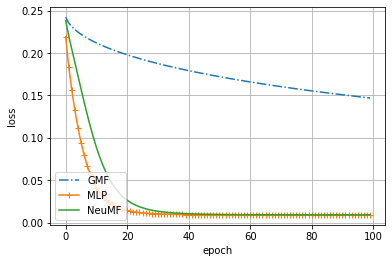

In [27]:
import matplotlib.pyplot as plt

plt.plot(history2.history['mse'],'-.')
plt.plot(history3.history['mse'],'-+')
plt.plot(history4.history['mse'],'-')

# plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['GMF', 'MLP', 'NeuMF'], loc='lower left')
plt.show()

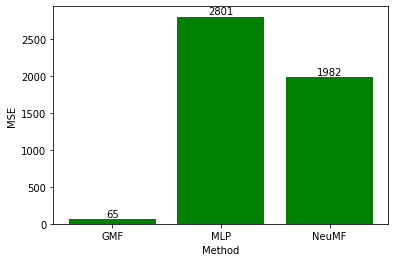

In [28]:
import matplotlib.pyplot as plt
labels = ['GMF', 'MLP', 'NeuMF']

energy = [
    65
    , 2801
    , 1982
]

# Plot the bar graph
plot = plt.bar(labels, energy, color='green')

# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x()+value.get_width()/2.,1.002*height,'%d'%int(height),ha='center',va='bottom')
plt.xlabel("Method")
plt.ylabel("MSE")
# Display the graph on the screen
plt.show()

In [29]:
test1 = model2.evaluate(x_test, y_test)
test2 = model3.evaluate(x_test, y_test)
test3 = model4.evaluate(x_test, y_test)
print(test1[2], test2[2], test3[2])

1378/1378 [==============================] - 2s 1ms/step - loss: 0.0543 - accuracy: 0.9904 - mse: 0.0095
0.14687760174274445 0.009469693526625633 0.009487672708928585


In [30]:
energy = [
#     history.history['root_mean_squared_error'][99]
    history2.history['val_mse'][99]
    , history3.history['val_mse'][99]
    , history4.history['val_mse'][99]
]
energy

[0.14699693024158478, 0.009956889785826206, 0.00997228641062975]

In [31]:
model3.predict([[0,1]])

array([[0.01296295]], dtype=float32)

In [32]:
x_o = df_o.iloc[:, 0:-1].values
y_o = df_o.iloc[:,2:3].values


In [33]:
np.max(model3.predict(x_o))

0.02622881

In [34]:
test2 = model3.evaluate(x_o, y_o)

66/66 [==============================] - 0s 2ms/step - loss: 4.3606 - accuracy: 0.0000e+00 - mse: 0.9741


Real Life

In [71]:
re_user = 15
n = len(df['player_id'].unique())
u = np.full((n, ), re_user)
i = np.arange(n)

In [72]:
testsss = pd.DataFrame(
    {
        'user_id': u,
        'player_id': i
    }
);

In [73]:
testsss['rating'] = model4.predict( testsss.iloc[:, :].values)
testsss['player_code'] = unique_item

In [74]:
testsss

,user_id,player_id,rating,player_code
0,15,0,0.016039,zgqjravo
1,15,1,0.013771,nngznqno
2,15,2,0.013021,dlkkbbwz
3,15,3,0.016772,bbzrkjpg
4,15,4,0.014302,bbnpmqam
...,...,...,...,...
897,15,897,0.012977,jrmooqyd
898,15,898,0.015894,krwnnmlo
899,15,899,0.011549,wvvprrjw
900,15,900,0.015060,mllzdngl


In [75]:
# r_cols = ['user_id', 'player_id', 'rating']
names_list = pd.read_csv('player_name.csv', sep=',')
names_list

,ID,name,season
0,adamlkmog,Adrien Rabiot,Paris Saint-Germain
1,adamlmkvr,Sébastien Cibois,Paris Saint-Germain
2,alkkaadr,Giuliano,LIVE
3,alkkabav,Christer Gustafsson,LIVE
4,alkkabgm,Giacomo Bonaventura,LIVE
...,...,...,...
23033,zzolkovp,Juan Sebastián Verón,ICON
23034,zzolzrvq,David Seaman,ICON
23035,zzolzvll,Gianfranco Zola,ICON
23036,zzozbzjr,Paulo Futre,ICON


In [76]:
recommendation = pd.merge(testsss, names_list, left_on = 'player_code', right_on='ID', how = 'left')
recommendation

,user_id,player_id,rating,player_code,ID,name,season
0,15,0,0.016039,zgqjravo,zgqjravo,Cristiano Ronaldo,Top Transfer
1,15,1,0.013771,nngznqno,nngznqno,Lionel Messi,Nation Hero Debut
2,15,2,0.013021,dlkkbbwz,dlkkbbwz,Kylian Mbappe Lottin,LIVE
3,15,3,0.016772,bbzrkjpg,bbzrkjpg,Patrick Vieira,Top Transfer
4,15,4,0.014302,bbnpmqam,bbnpmqam,Eusébio,Tournament Champions
...,...,...,...,...,...,...,...
897,15,897,0.012977,jrmooqyd,jrmooqyd,Franck Ribéry,Loyal Heroes
898,15,898,0.015894,krwnnmlo,krwnnmlo,Simon Mignolet,Best Of Europe
899,15,899,0.011549,wvvprrjw,wvvprrjw,Jordan Henderson,20 Team Of The Season
900,15,900,0.015060,mllzdngl,mllzdngl,Sadio Mané,20 Team Of The Season


In [77]:
exists = df_o.loc[df_o['user_id'] == re_user]
exists['player_id'] = exists.player_id.apply(lambda x: unique_item[x])
exists = pd.merge(exists, names_list, left_on = 'player_id', right_on='ID', how = 'left')
recommendation = recommendation[~recommendation['player_id'].isin(exists['player_id'].values)]

In [78]:
recommendation.sort_values(by = ['rating'], ascending = False)[['name','season','rating']].head(10)

,name,season,rating
293,Ronaldo,Heroes Of the Team,0.020171
18,Emmanuel Petit,Nation Hero Debut,0.019446
556,Raphaël Varane,Tournament Best,0.019441
316,Gary Lineker,Heroes Of the Team,0.018963
309,Harry Maguire,18 premium live class Spring,0.018694
835,Kyle Walker,19 Uefa Champions League,0.018042
84,Heung Min Son,Tournament Best,0.018026
17,Ronaldo,Top Transfer,0.017993
334,George Best,Tournament Champions,0.017879
21,Ruud Gullit,Top Transfer,0.017858


In [79]:
exists[['name','season']]

,name,season
0,Gianluigi Donnarumma,LIVE
1,Raphaël Varane,19 Team of the Year
2,Theo Hernández,LIVE
3,Ronaël PierreGabriel,Golden Rookies
4,Ruud Gullit,Top Transfer
5,Patrick Vieira,Nation Hero Debut
6,Thierry Henry,Top Transfer
7,Kylian Mbappe Lottin,19 Team of the Year
8,Cristiano Ronaldo,19 Team of the Year
9,Ronaldo,Top Transfer
